## Federated-Transfer learning Tutorial − Integrating Transfer learning to Federated Learning using MEDFl package

@Author : [MEDomics consortium](https://github.com/medomics/)

@Email : medomics.info@gmail.com

## Introduction

This notebook demonstrates the process of integrating [Transfer learning](https://ieeexplore.ieee.org/abstract/document/5288526/) using the *MEDFl* package. The primary objective of incorporating transfer learning with the package is to harness the capabilities of [Federated-Transfer learning](https://link.springer.com/chapter/10.1007/978-3-031-11748-0_3) in training models across different hospitals. In real-world scenarios, one of the clients or the aggregating server might possess a [pre-trained model](https://blogs.nvidia.com/blog/what-is-a-pretrained-ai-model/#:~:text=A%20pretrained%20AI%20model%20is,8%2C%202022%20by%20Angie%20Lee). Leveraging this pre-trained model offers advantages such as enhancing performance and reducing training time.

In some instances, a client may lack sufficient data to train a model entirely from scratch, hindering the ability to achieve optimal performance. Utilizing transfer learning becomes a viable strategy to maximize the benefits from each client, allowing the integration of previously learned knowledge to enhance model training and performance.

<img src="../Images/FTL_comp.png"  style="width:600px ;height:400px ; display:block ;margin:0 auto"> 

### EiCu Data 
This tutorial involves the utilization of the eICU dataset, a CSV file contains information on 200,860 patients, to train a binary classifier model.


## Tutorial Start

To integrate Transfer Learning into the *MEDFl* package, several sequential steps are essential:

1. **Importing a Pretrained Model:** Acquire or utilize a pretrained model containing learned knowledge from prior tasks or domains.
2. **Initialization at the Central Server:** The central server initiates its model by copying the pretrained model's parameters or weights.
3. **Initiating Federated Learning:** Upon initialization, the federated learning process begins, facilitating the exchange of model updates among participating clients for joint model training.

### Importing a Pretrained Model:
   - When importing a pretrained model, there are two options available:
   
     1. **Train and Save Locally:** Train a model localy, save it, and subsequently incorporate it for use.
     2. **External Source or Previous Work:** Import a pretrained model from an external source or retrieve it from a previous project.


### 1. Train and Save Localy
In this section, we aim to train a basic binary classifier model using the `eicu_sapsii_data.csv` dataset. Following the model training, we'll save the trained model for future utilization.

Imports

In [3]:
import sys
sys.path.append('../..')

import os
os.environ['PYTHONPATH'] = '../..'

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from Medfl.LearningManager.model import Model
from Medfl.LearningManager.utils import global_params

Read the data file

In [5]:
# Read the CSV file
data = pd.read_csv(global_params['base_url'] + '/notebooks/data/masterDataSet/eICU.csv')

data.head()

,hospitalid,age,pao2fio2,uo,aids,hem,mets,admissiontype,bicarbonate,bilirubin,bun,gcs,hr,potassium,sbp,sodium,tempc,wbc,deceased
0,73,78.0,0,900.00,0.0,0.0,0.0,6.0,18.0,1.50,48.0,13.00,118.0,4.9,74.0,146.0,37.0,13.3,1
1,73,47.0,0,2300.00,0.0,0.0,0.0,6.0,27.0,0.30,12.0,15.00,106.0,4.4,99.0,138.0,36.8,8.7,0
2,60,87.0,0,1308.15,0.0,0.0,0.0,6.0,22.0,0.30,36.0,15.00,96.0,5.4,91.0,148.0,36.7,8.8,0
3,73,67.0,6,130.00,0.0,0.0,0.0,6.0,16.0,0.10,106.0,15.00,102.0,4.7,179.0,146.0,37.2,7.3,0
4,73,81.0,0,1100.00,0.0,0.0,0.0,6.0,22.0,2.36,41.0,13.45,125.0,4.5,94.0,140.0,37.3,23.5,0


#### Data Preprocessing Steps

Here, we perform several essential data preprocessing steps:

1. **Drop Unnecessary Columns:** The code drops the 'subject_id' column and any other columns deemed unnecessary for the analysis. Additional columns can be added to the `columns_to_drop` list for removal.

2. **Define Features and Target Variable:** The features are defined by selecting all columns except the 'deceased' column, which is designated as the target variable for the binary classification task.

3. **Impute Missing Values:** Missing values in the selected features are imputed using the mean strategy. The `SimpleImputer` from the scikit-learn library is employed to fill missing values in the dataset.

4. **Preview the Transformed Data:** The `.head()` function is used to display the first few rows of the transformed dataset after preprocessing.

The code snippet provides a glimpse of the preprocessing steps, ensuring data cleanliness and preparation for training the binary classifier using the eICU dataset.


In [6]:
# Drop 'subject_id' column and any other unnecessary columns
columns_to_drop = ["hospitalid"]  # Add more columns to drop if needed
data.drop(columns=columns_to_drop, inplace=True)

# Define features and target variable
features = [col for col in data.columns if col != 'deceased']
target = 'deceased'

data.head()

,age,pao2fio2,uo,aids,hem,mets,admissiontype,bicarbonate,bilirubin,bun,gcs,hr,potassium,sbp,sodium,tempc,wbc,deceased
0,78.0,0,900.00,0.0,0.0,0.0,6.0,18.0,1.50,48.0,13.00,118.0,4.9,74.0,146.0,37.0,13.3,1
1,47.0,0,2300.00,0.0,0.0,0.0,6.0,27.0,0.30,12.0,15.00,106.0,4.4,99.0,138.0,36.8,8.7,0
2,87.0,0,1308.15,0.0,0.0,0.0,6.0,22.0,0.30,36.0,15.00,96.0,5.4,91.0,148.0,36.7,8.8,0
3,67.0,6,130.00,0.0,0.0,0.0,6.0,16.0,0.10,106.0,15.00,102.0,4.7,179.0,146.0,37.2,7.3,0
4,81.0,0,1100.00,0.0,0.0,0.0,6.0,22.0,2.36,41.0,13.45,125.0,4.5,94.0,140.0,37.3,23.5,0


#### Modal initialisation

In [7]:


X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = BinaryClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1]))
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data loaders for PyTorch
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)





In [33]:
input_dim

17

#### Modal Training 

In [8]:
# Train the model
epochs = 50
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader)}")

Epoch 1/50 - Loss: 1.3546791991951297
Epoch 2/50 - Loss: 1.2826889889897208
Epoch 3/50 - Loss: 1.2767062364347948
Epoch 4/50 - Loss: 1.2742994136116452
Epoch 5/50 - Loss: 1.27064395209215
Epoch 6/50 - Loss: 1.2669115716089774
Epoch 7/50 - Loss: 1.2649906115266192
Epoch 8/50 - Loss: 1.265447102648555
Epoch 9/50 - Loss: 1.2617384241461385
Epoch 10/50 - Loss: 1.2649189004957122
Epoch 11/50 - Loss: 1.2609047627670478
Epoch 12/50 - Loss: 1.2626235979629374
Epoch 13/50 - Loss: 1.2640358041683586
Epoch 14/50 - Loss: 1.2603604647766327
Epoch 15/50 - Loss: 1.2640962436472298
Epoch 16/50 - Loss: 1.2611603687053126
Epoch 17/50 - Loss: 1.2605726938498647
Epoch 18/50 - Loss: 1.2575866926934327
Epoch 19/50 - Loss: 1.2593563411257953
Epoch 20/50 - Loss: 1.2548004100935377
Epoch 21/50 - Loss: 1.258492506879033
Epoch 22/50 - Loss: 1.2578187688216336
Epoch 23/50 - Loss: 1.2561014731971103
Epoch 24/50 - Loss: 1.255131982612905
Epoch 25/50 - Loss: 1.2554575739999305
Epoch 26/50 - Loss: 1.2533895425014083


#### Evaluation

In [11]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = (outputs.squeeze() > 0.3).float()  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test_tensor.numpy(), predictions.numpy())
print(f"Test Accuracy: {accuracy:.2f}")

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_tensor.numpy(), predictions.numpy()))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tensor.numpy(), predictions.numpy()))

Test Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      2132
         1.0       0.33      0.68      0.45       447

    accuracy                           0.71      2579
   macro avg       0.62      0.70      0.62      2579
weighted avg       0.81      0.71      0.74      2579


Confusion Matrix:
[[1517  615]
 [ 143  304]]


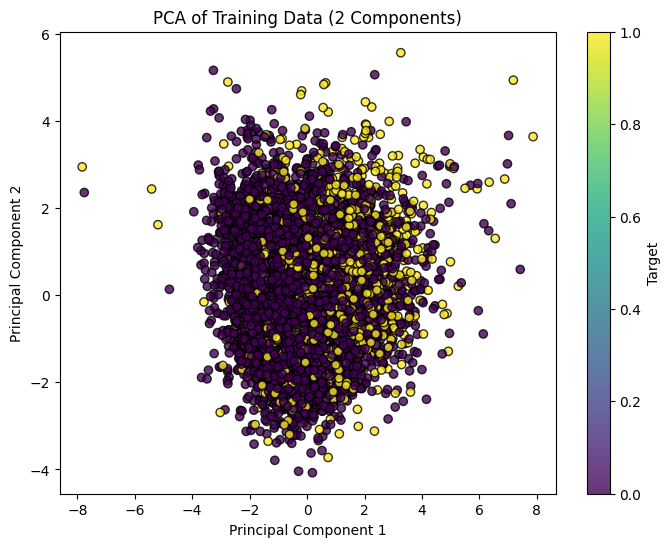

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA with 2 components
n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame for the PCA-transformed data
pca_df = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=y_train, cmap='viridis', edgecolors='k', alpha=0.8)
plt.title('PCA of Training Data (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target')
plt.show()